## Dengesiz Veri Seti
Bir iş için sınıflandırma modeli yaratıyorsunuz ve bu modelin doğruluk değeri %95 çıkıyor. Her şey güzel. Modeliniz kullanılmaya başlanıyor ama başarısız olduğu, her zaman aynı sınıfı tahminlediği fark ediliyor. Veri setini tekrar incelediğinizde tespit edilemeyen sınıfın veri setindeki oranın %5 olduğunu görüyorsunuz. Yani modelinizin başarısızlığı dengesiz veri setinden (Imbalanced Dataset) kaynaklı.

Dengesiz veri seti sınıflandırma problemlerinde görülür ve sınıf dağılımlarının birbirine yakın olmadığı durumlarda ortaya çıkar. Problem çoğunluğa sahip sınıfın azınlık sınıfını domine etmesinden kaynaklanır. Oluşturulan model çoğunluğa sahip sınıfa yakınlık gösterir, bu da azınlık sınıfının kötü sınıflandırılmasına sebep olur.

Dengesiz veri setleriyle karşılaştığımızda doğru gözlem yapabilmek ve dengeyi sağlayabilmek için uygulayabileceğimiz çeşitli yöntemler vardır:

*   Doğru Metrik Seçimi
  * Precision
  * Recall
  * F1-score
  * ROC Curve
  * AUC

* Resampling
  * Oversampling
    * Random Oversampling
    * SMOTE Oversampling
  * Undersampling
    * Random Undersampling
    * NearMiss Undersampling
    * Undersampling (Tomek links)
    * Undersampling (Cluster Centroids)
* Daha fazla veri toplamak
* Sınıflandırma modellerinde bulunan “class_weight” parametresi kullanılarak azınlık ve çoğunluk sınıflarından eşit şekilde öğrenebilen model yaratılması,
* Tek bir modele değil , diğer modellerdeki performanslara da bakılması,
* Daha farklı bir yaklaşım uygulanıp Anomaly detection veya Change detection yapmak

Dengesizlik içeren Credit Card Fraud Detection veri setini inceleyip, daha sonrasında bu dengesizlikle başa çıkabilmek için veri setine çeşitli yöntemler uygulayacağız.

## Veri Setinin İncelenmesi
Kredi kartı şirketlerinin dolandırıcılığı tespit etmeleri önemlidir, müşterilerine yanlış ücretlendirilme yapılmasını istemezler.

Bu veri seti kullanılarak dolandırıcılık yapılmış kredi kartlarını tespit eden bir model oluşturulmak isteniliyor.

Veri seti eylül 2013'te avrupada kredi kartıyla yapılan işlemlerden ve bu işlemlerin fraud(dolandırıcılık) ise 1 değilse 0 olarak etiketlenmesiyle oluşmuştur. Gizlilik nedeniyle arka plan bilgisi çok fazla bulunmuyor ve "Time","Amount" değişkeni haricinde diğer değişkenler PCA(Principal component analysis) ile dönüştürülmüştür.

* "Time" : ilk işlem ile her işlem arasındaki saniye
* "Amount": maliyet

ilk olarak veri setini okutup, boş değer olup olmadığını gözlemleyip, Class değişkenin dağılımına bakacağız. Daha sonrasında "Amount" ve "Time" değişkenini standartlaştırıyoruz. Veriyi hold out yöntemiyle ayırıp, sınıflandırma modeli olan logistic regression ile modeli oluşturuyoruz. Tek bir model üzerinden gideceğiz.

In [1]:
# Gerekli kütüphaneler
import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report,f1_score,recall_score,roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc,rcParams
import itertools

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [6]:
# Veri setinin okutulması
df = pd.read_csv("datasets/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
# Veri setindeki değişken ve gözlem sayısı
print("Gözlem sayısı : " ,len(df))
print("Değişken sayısı : ", len(df.columns))

Gözlem sayısı :  284807
Değişken sayısı :  31


In [8]:
# veri setindeki değişkenlerin tiplerini ve boş değer içerip içermediğini gözlemlemek istiyoruz
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

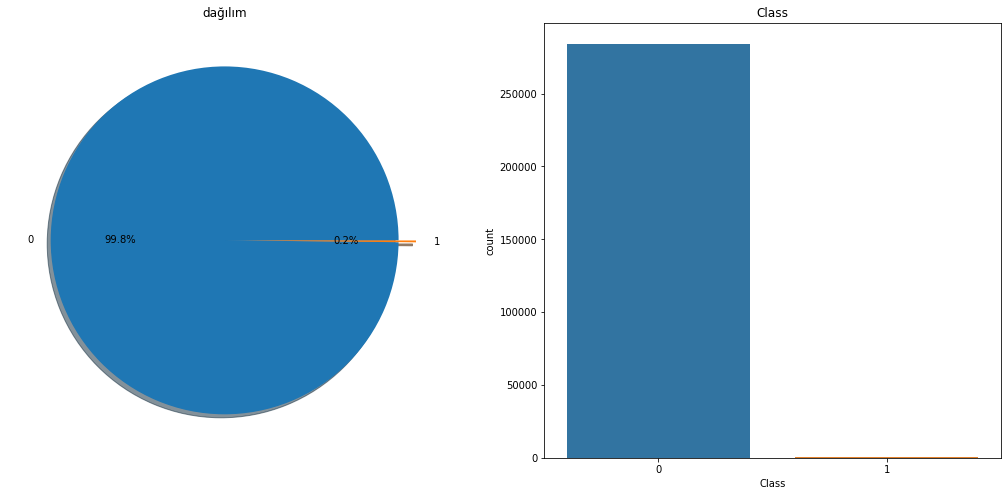

In [9]:
# 1 sınıfının veri setinde bulunma oranı %0.2, 0 sınıfının ise %99.8
f,ax=plt.subplots(1,2,figsize=(18,8))
df['Class'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('dağılım')
ax[0].set_ylabel('')
sns.countplot('Class',data=df,ax=ax[1])
ax[1].set_title('Class')
plt.show()

In [10]:
# Time ve Amount değişkenlerini standartlaştırma
rob_scaler = RobustScaler()
df['Amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['Time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,0
1,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,0
2,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,0
3,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,0
4,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,0


In [11]:
# Hold out yöntemi uygulayıp veri setini eğitim ve test olarak ikiye ayırıyoruz.(%80,%20)
X = df.drop("Class", axis=1)
y = df["Class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123456)

In [12]:
# modelin tanımlanıp, eğitilmesi ve başarı skoru
model = LogisticRegression(random_state=123456)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.3f"%(accuracy))

Accuracy: 0.999


**Accuracy** sistemde doğru olarak yapılan tahminlerin tüm tahminlere oranıdır.

Oluşturduğumuz modelin doğruluk skoru 0.999. Modelimiz mükemmel çalışıyor diyebiliriz, değil mi?

Performansını incelemek için birde Confusion Matrix'ine bakalım.

## Confusion Matrix
Confusion Matrix, bir sınıflandırma modelinin gerçek değerlerinin test verisi üzerindeki performansını açıklamak için kullanılan bir tablodur.

Tahmini ve gerçek değerlerin 4 farklı kombinasyonunu içermektedir.

![alt text](datasets/Confusion_matrix.png "Title")

* True Positives (TP) : Pozitif tahmin edildi ve bu doğru.
* True Negative (TN) : Negatif tahmin edildi ve bu doğru.
* False Positive (FP) : Pozitif tahmin edildi ve bu yanlış.
* False Negative (FN) : Negatif tahmin edildi ve bu yanlış.

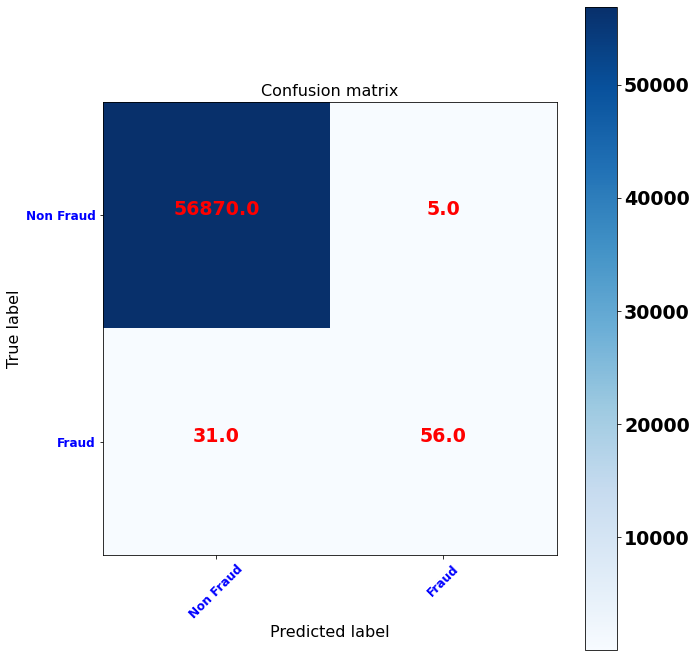

In [18]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 19})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontdict={'size':'16'})
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=12,color="blue")
    plt.yticks(tick_marks, classes,fontsize=12,color="blue")
    rc('font', weight='bold')
    fmt = '.1f'
    thresh = cm.max()
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red")

    plt.ylabel('True label',fontdict={'size':'16'})
    plt.xlabel('Predicted label',fontdict={'size':'16'})
    plt.tight_layout()

plot_confusion_matrix(confusion_matrix(y_test, y_pred=y_pred), classes=['Non Fraud','Fraud'],
                      title='Confusion matrix')